<h1>Problem Statement:</h1>

Consider that a real estate company has the data of real-estate prices in Delhi. The company wants to optimise the selling price of the properties, based on important factors such as area, bedrooms, parking, etc.

 
Essentially, the company wants:

To identify the variables affecting house prices, e.g., area, number of rooms, bathrooms, etc.
To create a linear model that quantitatively relates house prices with variables, such as the number of rooms, area, number of bathrooms, etc.
To know the accuracy of the model, i.e. how well do these variables predict the house prices

<b> So interpretation is important </b>

Steps followed: <br>
1. Reading, understanding and visualising teh data <br>
2. Preparing the data for modelling (test-train split, rescaling etc)<br>
3. Training the model <br>
4. Residual analysis <br>
5. Prediction and evalution on the test set <br>

# Step 1: Reading, understanding and visualising the data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data
housing = pd.read_csv('housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
housing.shape

(545, 13)

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
price               545 non-null int64
area                545 non-null int64
bedrooms            545 non-null int64
bathrooms           545 non-null int64
stories             545 non-null int64
mainroad            545 non-null object
guestroom           545 non-null object
basement            545 non-null object
hotwaterheating     545 non-null object
airconditioning     545 non-null object
parking             545 non-null int64
prefarea            545 non-null object
furnishingstatus    545 non-null object
dtypes: int64(6), object(7)
memory usage: 40.5+ KB


There are no missing values in this data.

In [5]:
housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


# Visualizing the data

Here,<br>
firstly : Uisng pairplots we want to check if linear regression makes sense or not. As in if price is linearly related to any of the variables. <br>
Secondly : We want to check the multicollinearity between the variables. As in if any independent/ predictor variables have high correlation<br>

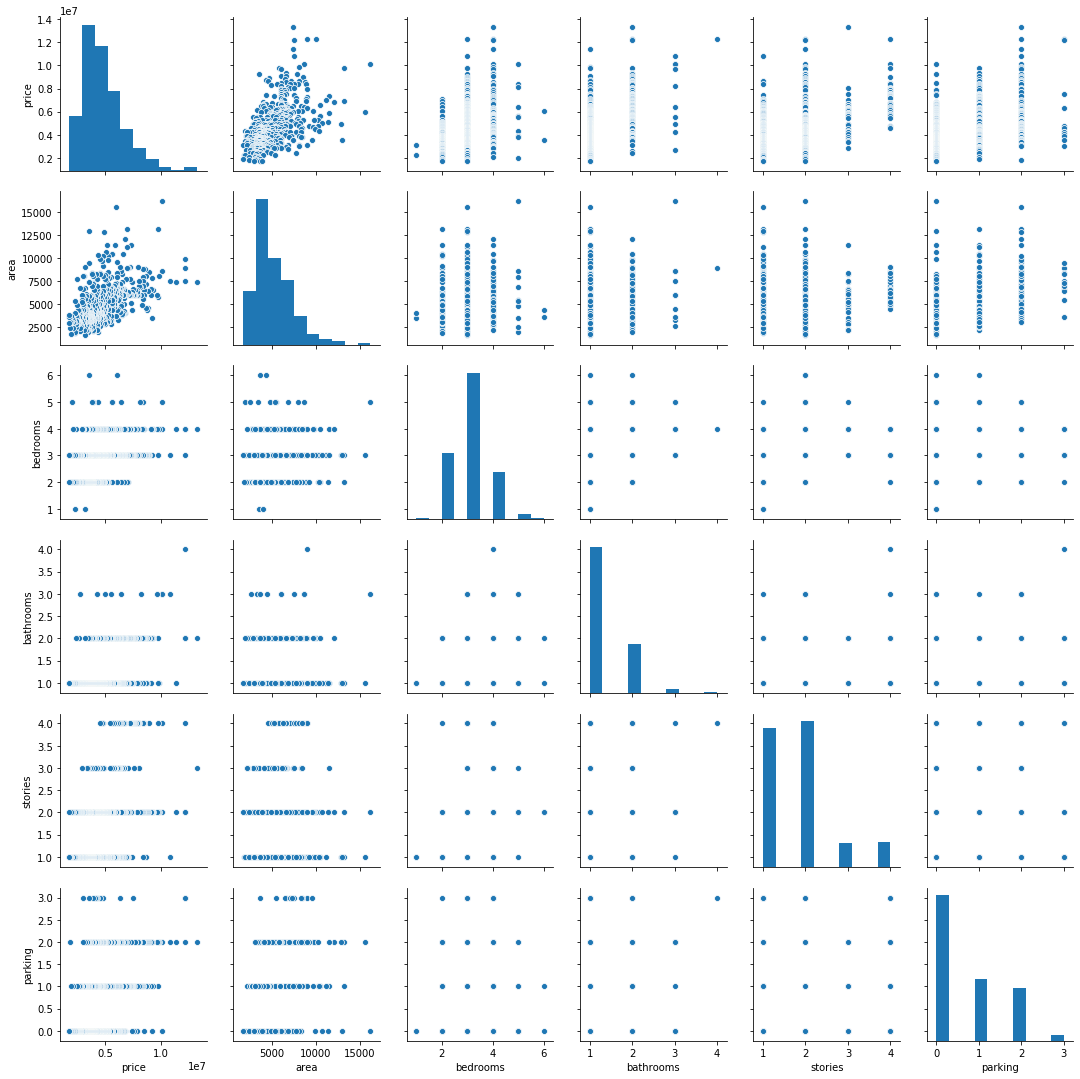

In [6]:
#visualizing the numerical variables
sns.pairplot(housing)
plt.show()

Along the diagonal we can see the histograms <br>
First column shows the relation between price and other variables.<br>
(x vs y plot): <br>
Price vs Price: Does not look like suspicious distribution.There are no spikes and the distribution is left skewed normal distribution. <br>

Price vs Area: There is a positive correlation between price and area. Implies, there are some data points in the area variables that helps to expect or predict the area. <br>

Price vs Bedrooms: Y axis (bedrooms) is categorical , the scatter plot is bit different. More the bedrooms higher the price. But again for 2-4 bedrooms the price is also high.<br>

Stories and parking doesnot show much good relation as theere are some gaps in the categorical scatter plot of the graph. <br>


Therefore, here we can consider linear regression model has there are some variables which shows the positive correlation.

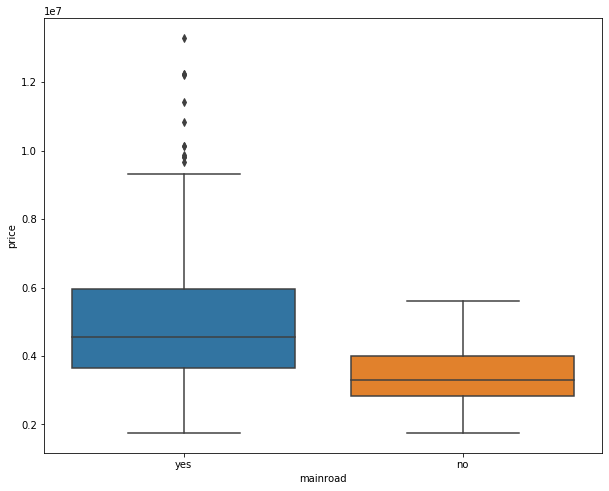

In [7]:
# since there are few categorical variables in the give data.
# We can also visualize the relation between categorical and continuous variable is 
# using "boxplot"

plt.figure(figsize=(10,8)) # this is to control the size
sns.boxplot(x='mainroad',y='price', data= housing)
plt.show()

If the mainroad is 'yes' then the distribution median is higher than the distribution with mainroad='no'.And the overall distribution is also on the higher side, when compared to the distribution with mainroad='no'

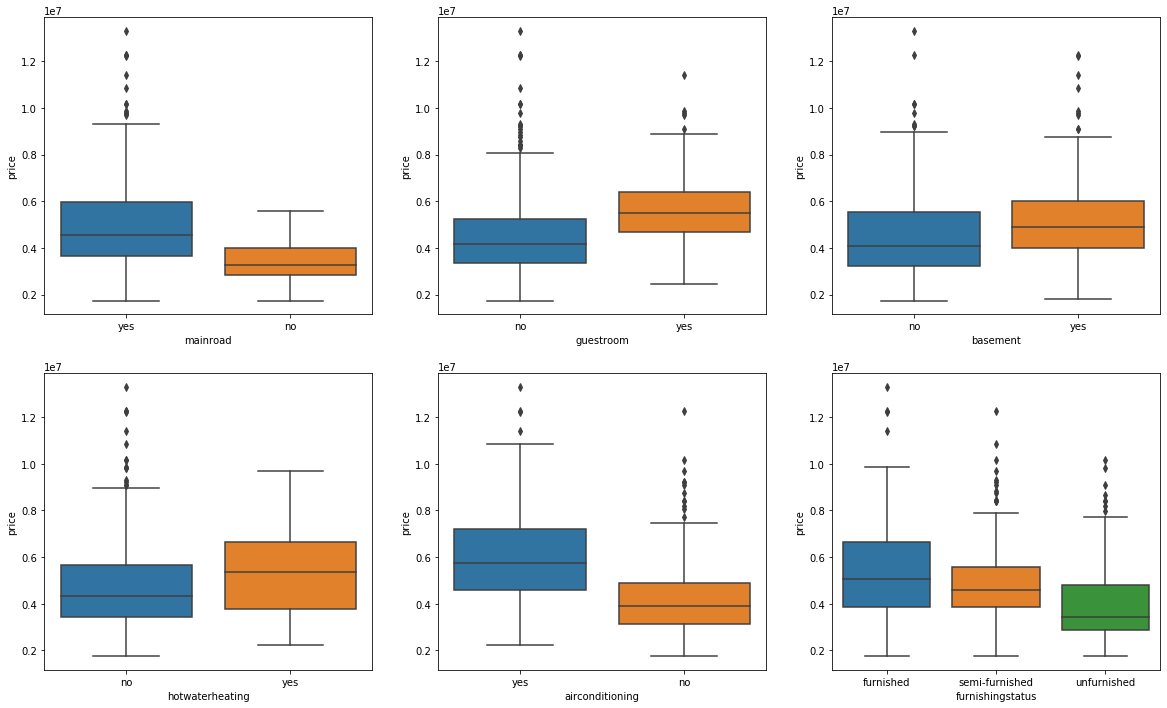

In [8]:
# creating subplots as there are more number of categorical variables

plt.figure(figsize=(20,12)) # this is to control the size
plt.subplot(2,3,1)
sns.boxplot(x='mainroad',y='price', data= housing)

plt.subplot(2,3,2)
sns.boxplot(x='guestroom',y='price', data= housing)

plt.subplot(2,3,3)
sns.boxplot(x='basement',y='price', data= housing)

plt.subplot(2,3,4)
sns.boxplot(x='hotwaterheating',y='price', data= housing)

plt.subplot(2,3,5)
sns.boxplot(x='airconditioning',y='price', data= housing)

plt.subplot(2,3,6)
sns.boxplot(x='furnishingstatus',y='price', data= housing)

plt.show()

guestroom vs price: house with guestroom = 'yes' are significantly at higher costs.

basement vs price: house with basement = 'yes' are slightly at higher costs.

hotwaterheating vs price: house with  hotwaterheating= 'yes' are slightly at higher costs.

airconditioning vs price: house with airconditioning = 'yes' are at higher costs.

furninshingstatus vs price: slight difference between the furninsging and semifurnishing houses.

# Step 2: Data prepration for modelling

1) Encoding- <br>
converting binary vars to 1/0 <br>
other categorical vars to dummy vars <br>

2) Splitting into train and test <br>

3) Rescaling of variables <br>

In [9]:
# yes/no variables
# we initialy create a list of variables which have yes/no values in it.

varlist = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
housing[varlist].head()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,yes,no,no,no,yes,yes
1,yes,no,no,no,yes,no
2,yes,no,yes,no,no,yes
3,yes,no,yes,no,yes,yes
4,yes,yes,yes,no,yes,no


In [10]:
housing[varlist]= housing[varlist].apply(lambda x:x.map({'yes':1,'no':0}))
housing[varlist].head()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,1,0,0,0,1,1
1,1,0,0,0,1,0
2,1,0,1,0,0,1
3,1,0,1,0,1,1
4,1,1,1,0,1,0


In [11]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [12]:
housing['furnishingstatus'].head()

0         furnished
1         furnished
2    semi-furnished
3         furnished
4         furnished
Name: furnishingstatus, dtype: object

For one of the columns in housing- 'furnishingstatus', we have three levels. Hence, we need to perform dummy coding

In [13]:
#converting furnishing status 

#first create dummy variables for 3 categorical values in the furnishing status variable.

#creating dummy variables
status = pd.get_dummies(housing['furnishingstatus'])
status

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
540,0,0,1
541,0,1,0
542,0,0,1
543,1,0,0


 1 0 0 => furnished <br>
 0 1 0 => semi-furnished <br>
 0 0 1 => unfurnished <br>
 
 Here we can drop the furnished column and conclude the below <br>

- 00 will correspond to "Furnished". <br>
- 01 will correspond to "unfurnished". <br>
- 10 will correspond to "Semi-furnished". <br>

In [14]:
# to show above 
status = pd.get_dummies(housing['furnishingstatus'],drop_first=True)
status

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
540,0,1
541,1,0
542,0,1
543,0,0


In [15]:
# these dummy variables are stored in status and now we need to join this
# with orginal data frame by using concat.

housing = pd.concat([housing,status],axis=1)

#axis=1 horizontal concat 
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [16]:
#dropping the furnishingstatus variable

housing = housing.drop(columns= ['furnishingstatus'])
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


Now , we can do the test-train split and scalling teh features.

<h2> Spliting into test and train set </h2>

In [17]:
# importing the required packages

import sklearn
from sklearn.model_selection import train_test_split

In [18]:
df_train, df_test= train_test_split(housing, train_size=0.7,random_state=100)
print(df_train.shape)
print(df_test.shape)

(381, 14)
(164, 14)


 <h2> Rescaling the features </h2>

In [19]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 14 columns):
price              545 non-null int64
area               545 non-null int64
bedrooms           545 non-null int64
bathrooms          545 non-null int64
stories            545 non-null int64
mainroad           545 non-null int64
guestroom          545 non-null int64
basement           545 non-null int64
hotwaterheating    545 non-null int64
airconditioning    545 non-null int64
parking            545 non-null int64
prefarea           545 non-null int64
semi-furnished     545 non-null uint8
unfurnished        545 non-null uint8
dtypes: int64(12), uint8(2)
memory usage: 52.2 KB


Except for area , all the other columns have small integer values.So,it is extremely important to rescale the variables so that they have a comparable scale.If we dont have comparable scale, them some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. 

In [20]:
# normalization or minmax scaling: (x-xmin)/(xmax-xmin)
# first import reqpackages for this
from sklearn.preprocessing import MinMaxScaler

In [21]:
# instantiate the minmaxscaler object
scaler = MinMaxScaler()

In [22]:
# fit teh scaler on teh train data
# we only need to scale the numeric variables here as the other binary variables
# with values 0 and 1 doesn't need this. As 0-> No and 1->Yes
# Hence, here we are only rescaling the numeric variables

num_vars= ['area','bedrooms','bathrooms','stories','parking','price']

df_train[num_vars]= scaler.fit_transform(df_train[num_vars])

In [23]:
#scaler.fit():this learns the max and min values of the data
#transform(): After fit, this functions calculates x-xmin/xmax-xmin
#fit_transform() : this is combination of fit and tranform

In [24]:
df_train[num_vars].head()

,area,bedrooms,bathrooms,stories,parking,price
359,0.155227,0.4,0.0,0.000000,0.333333,0.169697
19,0.403379,0.4,0.5,0.333333,0.333333,0.615152
159,0.115628,0.4,0.5,0.000000,0.000000,0.321212
35,0.454417,0.4,0.5,1.000000,0.666667,0.548133
28,0.538015,0.8,0.5,0.333333,0.666667,0.575758


In [25]:
df_train[num_vars].describe()

,area,bedrooms,bathrooms,stories,parking,price
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.288710,0.386352,0.136483,0.268591,0.242345,0.260333
std,0.181420,0.147336,0.237325,0.295001,0.285933,0.157607
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.155227,0.200000,0.000000,0.000000,0.000000,0.151515
50%,0.234424,0.400000,0.000000,0.333333,0.000000,0.221212
75%,0.398099,0.400000,0.500000,0.333333,0.333333,0.345455
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# we can see that the max value is 1.

# Step 3: Training the Model

In [27]:
# Now, will all the variables will be part of variable? Only few will be part?
# if so based on what???
# Way1 - Start with all the other variables then based on some criteria delete the variables.
# Way2 (bottom up approach) - start with one variable and then build by adding more variables.

#Lets take the way-2 as our approach. 

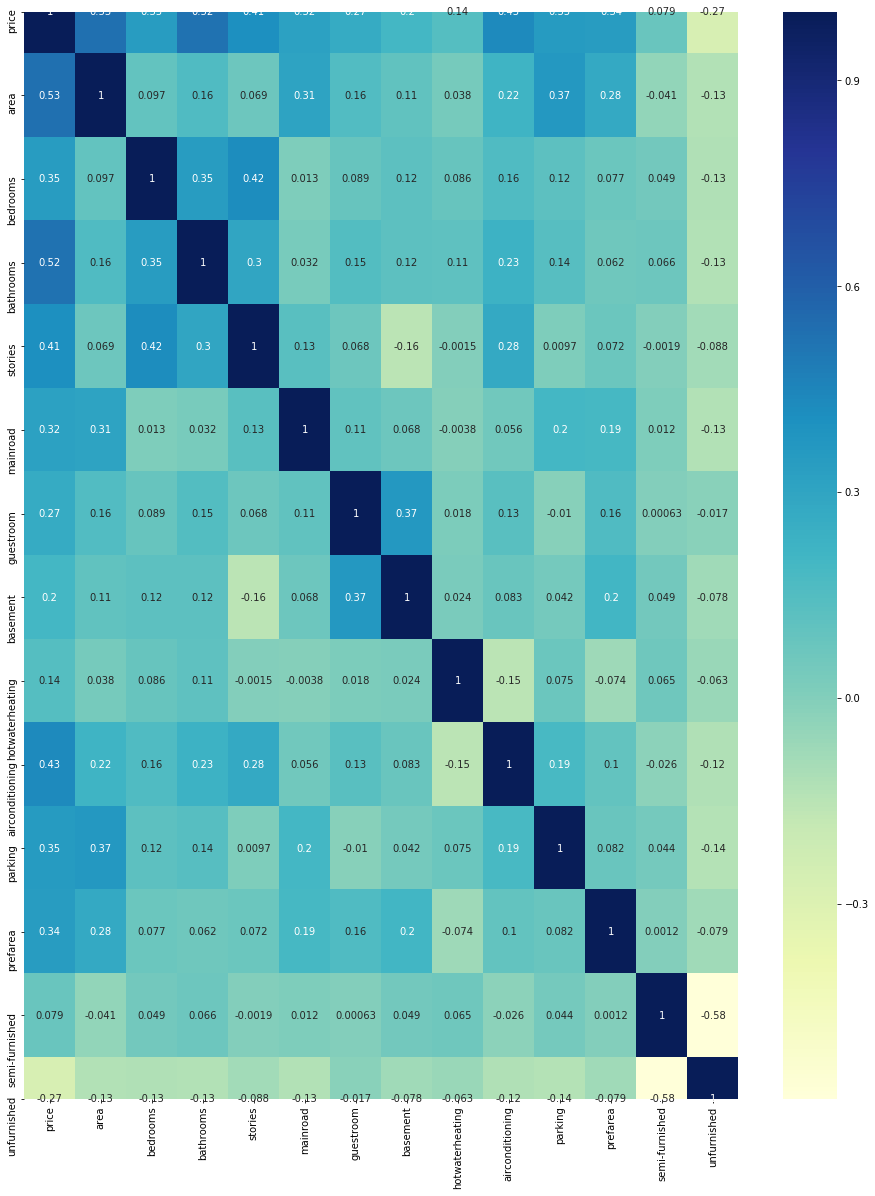

In [28]:
plt.figure(figsize=(16,20))
sns.heatmap(df_train.corr(),annot=True,cmap="YlGnBu")
plt.show()

In [29]:
# in the first column- area is correlated with price with .52 and bathroom is correlated with .52

In [30]:
#we can start with area and then move on
#x_train, y_train from df_train
#y_train will be price
#x_train will be other

y_train = df_train.pop('price')
X_train = df_train

In [31]:
y_train

359    0.169697
19     0.615152
159    0.321212
35     0.548133
28     0.575758
         ...   
526    0.048485
53     0.484848
350    0.175758
79     0.424242
520    0.060606
Name: price, Length: 381, dtype: float64

In [32]:
X_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,0.118268,0.2,0.0,0.000000,1,0,0,0,0,0.000000,0,0,1
53,0.291623,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,1,0
350,0.139388,0.2,0.0,0.333333,1,0,0,1,0,0.333333,0,1,0
79,0.366420,0.4,0.5,0.666667,1,1,0,0,1,0.000000,0,0,0


In [33]:
#keep on adding vars and check the statistical significance of the variables
#and VIF to check collinearity with other vars

In [34]:
import statsmodels.api as sm

# first we need to add constant as statsmodel doesnot add this

X_train_sm = sm.add_constant(X_train['area'])
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.params

const    0.126894
area     0.462192
dtype: float64

In [35]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     149.6
Date:                Fri, 17 Jul 2020   Prob (F-statistic):           3.15e-29
Time:                        02:02:21   Log-Likelihood:                 227.23
No. Observations:                 381   AIC:                            -450.5
Df Residuals:                     379   BIC:                            -442.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1269      0.013      9.853      0.000       0.102       0.152
area           0.4622      0.038     12.232      0.000       0.388       0.536
==============================================================================
Omnibus:                       67.313   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.063
Skew:                           0.925   Prob(JB):                     8.59e-32
Kurtosis:                       5.365   Cond. No.                         5.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

p vlue is 0 => result is statistcally significant
r squared is 0.283=> 28% of variance in price is explained by the area <br>
Now we add another variable

In [36]:
# add another variable
# checking correlation bath room has next high value

X_train_sm = X_train[['area','bathrooms']]
X_train_sm = sm.add_constant(X_train_sm)

lr= sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.params

const        0.104589
area         0.398396
bathrooms    0.298374
dtype: float64

In [37]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     174.1
Date:                Fri, 17 Jul 2020   Prob (F-statistic):           2.51e-54
Time:                        02:02:21   Log-Likelihood:                 288.24
No. Observations:                 381   AIC:                            -570.5
Df Residuals:                     378   BIC:                            -558.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1046      0.011      9.384      0.000       0.083       0.127
area           0.3984      0.033     12.192      0.000       0.334       0.463
bathrooms      0.2984      0.025     11.945      0.000       0.249       0.347
==============================================================================
Omnibus:                       62.839   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.790
Skew:                           0.784   Prob(JB):                     2.23e-37
Kurtosis:                       5.859   Cond. No.                         6.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R squared has gone to 48% form 28%.wherein, this model explains the 48% of teh variance of price.

Now ,a dding next high correlated var-

In [38]:
X_train_sm = X_train[['area','bathrooms','bedrooms']]
X_train_sm = sm.add_constant(X_train_sm)

lr= sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.params

const        0.041352
area         0.392211
bathrooms    0.259978
bedrooms     0.181863
dtype: float64

In [39]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     128.2
Date:                Fri, 17 Jul 2020   Prob (F-statistic):           3.12e-57
Time:                        02:02:21   Log-Likelihood:                 297.76
No. Observations:                 381   AIC:                            -587.5
Df Residuals:                     377   BIC:                            -571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0414      0.018      2.292      0.022       0.006       0.077
area           0.3922      0.032     12.279      0.000       0.329       0.455
bathrooms      0.2600      0.026     10.033      0.000       0.209       0.311
bedrooms       0.1819      0.041      4.396      0.000       0.101       0.263
==============================================================================
Omnibus:                       50.037   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.806
Skew:                           0.648   Prob(JB):                     7.92e-28
Kurtosis:                       5.487   Cond. No.                         8.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# this process will become tedious in case of many variables.

<h2> Approach-2 - Adding all the variables to the model </h2>


In [41]:
housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished'],
      dtype='object')

In [42]:
X_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,0.118268,0.2,0.0,0.000000,1,0,0,0,0,0.000000,0,0,1
53,0.291623,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,1,0
350,0.139388,0.2,0.0,0.333333,1,0,0,1,0,0.333333,0,1,0
79,0.366420,0.4,0.5,0.666667,1,1,0,0,1,0.000000,0,0,0


In [43]:
#build model with all teh variables

#adding constant
X_train_sm = sm.add_constant(X_train)

#create model
lr=sm.OLS(y_train,X_train_sm)

#fit model
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Fri, 17 Jul 2020   Prob (F-statistic):           8.83e-83
Time:                        02:02:21   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -735.6
Df Residuals:                     367   BIC:                            -680.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0200      0.021      0.955      0.340      -0.021       0.061
area                0.2347      0.030      7.795      0.000       0.175       0.294
bedrooms            0.0467      0.037      1.267      0.206      -0.026       0.119
bathrooms           0.1908      0.022      8.679      0.000       0.148       0.234
stories             0.1085      0.019      5.661      0.000       0.071       0.146
mainroad            0.0504      0.014      3.520      0.000       0.022       0.079
guestroom           0.0304      0.014      2.233      0.026       0.004       0.057
basement            0.0216      0.011      1.943      0.053      -0.000       0.043
hotwaterheating     0.0849      0.022      3.934      0.000       0.042       0.127
airconditioning     0.0669      0.011      5.899      0.000       0.045       0.089
parking             0.0607      0.018      3.365      0.001       0.025       0.096
prefarea            0.0594      0.012      5.040      0.000       0.036       0.083
semi-furnished      0.0009      0.012      0.078      0.938      -0.022       0.024
unfurnished        -0.0310      0.013     -2.440      0.015      -0.056      -0.006
==============================================================================
Omnibus:                       93.687   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.917
Skew:                           1.091   Prob(JB):                     6.14e-67
Kurtosis:                       6.801   Cond. No.                         14.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

p value of constant is high => line passes thru (0,0)
p values of semi-furinshed is 0.938 is very high.

P value < 0.05 is basically good

Now, based on significance of the variables (i.e. p value) we can drop the variables.
And supplement based on the VIF of the variables.

<b> Variance Inflation factor or VIF of the variable </b>,gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely importnat parameter to test our linear model. The formula for calculating VIF is:

VIF = 1 / 1-Ri square <br>


We are checking the VIF and significance value so to balance both these values of the variables while droping it. <br>
Since there might be a scenario wherein the significance value is less and VIF is higher.

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
#create a dataframe that will contain names of all the feature variables and
#their VIF 

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF",ascending = False)
vif

,Features,VIF
1,bedrooms,7.33
4,mainroad,6.02
0,area,4.67
3,stories,2.70
11,semi-furnished,2.19
9,parking,2.12
6,basement,2.02
12,unfurnished,1.82
8,airconditioning,1.77
2,bathrooms,1.67


Now, for bedrooms VIF is higher 7.33 but significance p level is within limits. And for semi-furnished p values is high 0.93 which is high. <br>
We will remove semi-furnished but not bedrooms. <br>

Reason- <br>
After removing semi-furnished (high p value), we build another model. Then VIF values includnig bedrooms will change, as VIF is measure of the variale which is correlated to other variables and here bedroom might be varible which is correlated more to semi-furnished.
<br>
So, VIF < 5 is considered here to drop variables-


Summary:
- High p value, high VIF = drop the variable
- High-Low:
       - High p, Low VIF = remove these first; after creating a model the VIFs of other variables might change/vary
       - Low p, High VIF = rmeove these after the ones above
- Low p, Low VIF - these are not correlated and can be retained.

In [46]:
X = X_train.drop('semi-furnished', axis=1)

In [47]:
#create another model without semi-furnishing

#adding constant
X_train_sm = sm.add_constant(X)

#create model
lr = sm.OLS(y_train,X_train_sm)

#fit
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Fri, 17 Jul 2020   Prob (F-statistic):           1.07e-83
Time:                        02:02:21   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -737.6
Df Residuals:                     368   BIC:                            -686.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0207      0.019      1.098      0.273      -0.016       0.058
area                0.2344      0.030      7.845      0.000       0.176       0.293
bedrooms            0.0467      0.037      1.268      0.206      -0.026       0.119
bathrooms           0.1909      0.022      8.697      0.000       0.148       0.234
stories             0.1085      0.019      5.669      0.000       0.071       0.146
mainroad            0.0504      0.014      3.524      0.000       0.022       0.079
guestroom           0.0304      0.014      2.238      0.026       0.004       0.057
basement            0.0216      0.011      1.946      0.052      -0.000       0.043
hotwaterheating     0.0849      0.022      3.941      0.000       0.043       0.127
airconditioning     0.0668      0.011      5.923      0.000       0.045       0.089
parking             0.0608      0.018      3.372      0.001       0.025       0.096
prefarea            0.0594      0.012      5.046      0.000       0.036       0.083
unfurnished        -0.0316      0.010     -3.096      0.002      -0.052      -0.012
==============================================================================
Omnibus:                       93.538   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.844
Skew:                           1.090   Prob(JB):                     1.05e-66
Kurtosis:                       6.794   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
#checking the vif
vif= pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by="VIF",ascending = False)
vif

,Features,VIF
1,bedrooms,6.59
4,mainroad,5.68
0,area,4.67
3,stories,2.69
9,parking,2.12
6,basement,2.01
8,airconditioning,1.77
2,bathrooms,1.67
10,prefarea,1.51
5,guestroom,1.47


VIF of bedrooms now reduced to 6.59 (though not significant). 
Now, bedrooms have p value of 0.2 and high VIF. so drop bedrooms

In [49]:
X = X.drop('bedrooms',axis=1)

In [50]:
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Fri, 17 Jul 2020   Prob (F-statistic):           2.73e-84
Time:                        02:02:21   Log-Likelihood:                 380.96
No. Observations:                 381   AIC:                            -737.9
Df Residuals:                     369   BIC:                            -690.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0357      0.015      2.421      0.016       0.007       0.065
area                0.2347      0.030      7.851      0.000       0.176       0.294
bathrooms           0.1965      0.022      9.132      0.000       0.154       0.239
stories             0.1178      0.018      6.654      0.000       0.083       0.153
mainroad            0.0488      0.014      3.423      0.001       0.021       0.077
guestroom           0.0301      0.014      2.211      0.028       0.003       0.057
basement            0.0239      0.011      2.183      0.030       0.002       0.045
hotwaterheating     0.0864      0.022      4.014      0.000       0.044       0.129
airconditioning     0.0665      0.011      5.895      0.000       0.044       0.089
parking             0.0629      0.018      3.501      0.001       0.028       0.098
prefarea            0.0596      0.012      5.061      0.000       0.036       0.083
unfurnished        -0.0323      0.010     -3.169      0.002      -0.052      -0.012
==============================================================================
Omnibus:                       97.661   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.388
Skew:                           1.130   Prob(JB):                     2.20e-71
Kurtosis:                       6.923   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# vif now
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by="VIF",ascending= False)
vif

,Features,VIF
3,mainroad,4.79
0,area,4.55
2,stories,2.23
8,parking,2.10
5,basement,1.87
7,airconditioning,1.76
1,bathrooms,1.61
9,prefarea,1.50
4,guestroom,1.46
10,unfurnished,1.33


Important of why considering VIF= 5 
5 = 1/(1-r2) <br>
1-r2 = 0.2 <br>
r2=0.8 <br>
This implies almost 80% variance in the variable is explained by all the other variables.

none of variables has vif > 5, and p values are not tremendously high.
So this will be the final model

# Step 4: Residual Analysis

Residual = actual ytrain - y predicted

In [52]:
#computing the predicted y values
y_train_pred = lr_model.predict(X_train_sm)

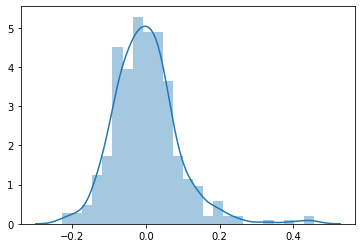

In [53]:
#plotting historgram
res= y_train - y_train_pred
sns.distplot(res)

This distrubtion of error terms should be normally distributed centred arond zero (one of main assumptions in LR)

# Step 5: Predictions and Evaluation on the Test Set

We have evaluated dmodel using Rsquare which is 68%. Now we evaluate using the test set <br>

Firstly we need to do the same tranformations on the test set same as we did in the train set<br>
i.e. rescaled the fatures in the train set using MinMaxScaler and converted training set into standardized values. <br>
So the preprocessing steps need to be repeated on the test data as well. <br>

Secondly, regarding the fit(),tranform() and fit_transform()- <br>
1) We never fit() on the test set - in predictive analytics fundamental diff in train and test set is that test set is not used to learn anything from the model.
This Test set should be a representation of the unseen data

you fit the scalrs on the train dataset and transform on the test dataset.

In [54]:
num_vars = ['area','bedrooms','bathrooms','stories','parking','price']

#fit on data
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.229697,0.091869,0.4,0.0,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.484848,0.366420,0.4,0.5,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.303030,0.742080,0.4,0.0,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.242424,0.306582,0.4,0.0,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.227879,0.274023,0.6,0.0,0.333333,1,0,0,0,1,0.000000,0,1,0


In [55]:
df_test.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.263176,0.298548,0.408537,0.158537,0.268293,0.865854,0.195122,0.347561,0.030488,0.353659,0.205285,0.237805,0.420732,0.329268
std,0.172077,0.211922,0.147537,0.281081,0.276007,0.341853,0.397508,0.477654,0.172452,0.479569,0.289322,0.427043,0.495189,0.471387
min,0.006061,-0.016367,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142424,0.148011,0.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.226061,0.259724,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.346970,0.397439,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,0.909091,1.263992,0.800000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


max values are not exactly 1 here.<br>
We have fit the scalar on the training data set, so the min and max the transform the scaler is using is from the training set.
i.e. Min-Max values of traning set is used to transform the test set

In [56]:
y_test = df_test.pop('price')
X_test = df_test

In [57]:
#add constant
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,1.0,0.091869,0.4,0.0,0.333333,1,0,0,0,0,0.000000,1,1,0
54,1.0,0.366420,0.4,0.5,0.333333,1,1,0,0,1,0.333333,0,1,0
171,1.0,0.742080,0.4,0.0,0.000000,1,0,0,0,0,0.333333,1,1,0
244,1.0,0.306582,0.4,0.0,0.333333,1,1,1,0,0,0.000000,1,1,0
268,1.0,0.274023,0.6,0.0,0.333333,1,0,0,0,1,0.000000,0,1,0


In [58]:
# removing the variables which we removes in traning set with high p and VIF.
X_test_sm = X_test_sm.drop(['bedrooms','semi-furnished'],axis=1)


In [59]:
#predict
y_test_pred= lr_model.predict(X_test_sm)

In [60]:
from sklearn.metrics import r2_score
#evaluate
r2_score(y_true=y_test, y_pred=y_test_pred)

0.6713505684480788

In [61]:
#traning set has r2square is 68% and test set also shows 67% nearer value.

We can see that the equaltion of our best fitted line is:
price = 0.236*area + 0.202*bathrooms + 0.11*stories + 0.05*mainroad + 0.04*guestrooms + 0.08*hotwaterheating + 0.06*airconditiong + 0.06*parking + 0.063*prefarea - 0.033 * unfurnished <br>

- if area increases by 1 unit price increases by 0.236 times.
- if unfurnished becomes 1 the price is decrease by 0.033
<br>

To make this model better,we could add new features : <br>
1  adding new features bathrooms/bedrooms , area/stories etc. <br>
2 Building a non-linear model- non linear regression technique which assumes underlining eq is not linear.